# Project Cars - MPG Prediction (Regression)
Copyright 2022, LEAKY.AI LLC

This is project 2 for the Introduction to Deep Learning with PyTorch course (www.leaky.ai).

In this project you will build a neural network from scratch and train it to automatically predict Miles per Gallon (MPG) for various types of cars by simply looking at other properties of the car. You will be working with a real-world car dataset which will include values for each car including the number of cylinders, horsepower, weight, model year and acceleration.  From these values, the goal of your neural network will be to predict the expected Mile per Gallon (MPG for short) of the car.

### In this project you will:
- Build and train a neural network from scratch to predict MPG (Miles per Gallon) for cars using other car attributes (year, model, displacement etc.)
- Prepare a real-world dataset of car attributes (along with MPGs) to be used for training the neural network
- Experiment with different models to achieve a target average loss (or better) on the test set
- Use the trained model to make new predictions of MPGs

### To get started:
- Open up a web browser (preferable Chrome)
- Copy the Project GitHub Link: https://github.com/LeakyAI/PyTorch-Overview
- Head over to Google Colab (https://colab.research.google.com)
- Load the notebook: Project Cars - START HERE.ipynb
- Replace the [TBD]'s with your own code
- Execute the notebook after completing each cell

### Hint
Don't forget to print out and have your PyTorch and Pandas Cheatsheet handy when tackling this project. You can find it on the right-hand side of the the course home landing page in the Resource section.

Good luck!

In [1]:
# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import math and visual libraries we will need
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set our seeds to get reproducible results
torch.manual_seed(4)
random.seed(4)

# Modify print options for numpy and pandas
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

### Load and Analyze the Dataset
Below you will download the car dataset and explore the different attributes.

In [2]:
# Dataset from UCI - https://archive.ics.uci.edu/ml/datasets/auto+mpg
# Dua, D. and Graff, C. (2019). UCI Machine Learning Repository Irvine, CA
# University of California, School of Information and Computer Science.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
cars = pd.read_csv(url, names=column_names, na_values='?', comment='\t', 
                   sep=' ', skipinitialspace=True)
cars['Origin']=cars['Origin'].replace({1:'USA',2:'Europe',3:'Japan'})
cars.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.00,8,307.00,130.00,"3,504.00",12.00,70,USA
1,15.00,8,350.00,165.00,"3,693.00",11.50,70,USA
2,18.00,8,318.00,150.00,"3,436.00",11.00,70,USA
3,16.00,8,304.00,150.00,"3,433.00",12.00,70,USA
4,17.00,8,302.00,140.00,"3,449.00",10.50,70,USA


In [3]:
cars.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
count,398.00,398.00,398.00,392.00,398.00,398.00,398.00
mean,23.51,5.45,193.43,104.47,"2,970.42",15.57,76.01
std,7.82,1.70,104.27,38.49,846.84,2.76,3.70
min,9.00,3.00,68.00,46.00,"1,613.00",8.00,70.00
25%,17.50,4.00,104.25,75.00,"2,223.75",13.83,73.00
50%,23.00,4.00,148.50,93.50,"2,803.50",15.50,76.00
75%,29.00,8.00,262.00,126.00,"3,608.00",17.18,79.00
max,46.60,8.00,455.00,230.00,"5,140.00",24.80,82.00


### Question:  What are some of the common dataset issues you see with the above tables that will need to tackled before we can use it for training neural networks?

Your Answer:   [TBD]

# Prepare our Dataset
### Start by counting and removing rows with missing items


In [4]:
# Determine the number of missing items from each attribute
cars.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
# Drop rows with missing items
cars = cars.dropna()

# Check all missing items have been removed
cars.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

### One-hot encode categorical attributes
Origin is a categorical attribute in this dataset.  Start by determining how many categories exits after dropping any missing items from above.

In [6]:
# Count number of unique values in each attribute including 'Origin'
cars.nunique()

MPG             127
Cylinders         5
Displacement     81
Horsepower       93
Weight          346
Acceleration     95
Model Year       13
Origin            3
dtype: int64

### Question:  How many unique categories exist for Origin?

Your Answer:  [TBD]

In [7]:
# OneHot encode the Origin attribute using pd.get_dummies, drop and pd.concat
oneHot = pd.get_dummies(cars['Origin'], prefix="Origin", drop_first=True)
cars=cars.drop('Origin',axis=1)
cars = pd.concat([cars,oneHot],axis=1)
cars.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Japan,Origin_USA
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,23.45,5.47,194.41,104.47,"2,977.58",15.54,75.98,0.20,0.62
std,7.81,1.71,104.64,38.49,849.40,2.76,3.68,0.40,0.48
min,9.00,3.00,68.00,46.00,"1,613.00",8.00,70.00,0.00,0.00
25%,17.00,4.00,105.00,75.00,"2,225.25",13.78,73.00,0.00,0.00
50%,22.75,4.00,151.00,93.50,"2,803.50",15.50,76.00,0.00,1.00
75%,29.00,8.00,275.75,126.00,"3,614.75",17.02,79.00,0.00,1.00
max,46.60,8.00,455.00,230.00,"5,140.00",24.80,82.00,1.00,1.00


### How many total attributes are left in the dataset after one hot encoding the Origin attribute?

Your Answer:  [TBD]

### Extract input X and output Y (MPG) from the dataset

In [8]:
# Extract our target output ydf (MPG) and input x attributes
ydf = cars['MPG']
xdf = cars.drop(['MPG'],axis=1)

### Apply standardization to our input xdf and output ydf 

In [9]:
# Calculate and save values required values to standardize both the input xdf and ydf
xMean = xdf.mean()
xStd = xdf.std()
yMean = ydf.mean()
yStd = ydf.std()

# Standardize both the input (xdf) and output (ydf) values
xdf = (xdf-xMean)/xStd
ydf = (ydf-yMean)/yStd

In [10]:
# Check the input xdf values are now standardized
xdf.describe()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Japan,Origin_USA
count,392.00,392.00,392.00,392.00,392.00,392.00,392.00,392.00
mean,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.45,-1.21,-1.52,-1.61,-2.73,-1.62,-0.50,-1.29
25%,-0.86,-0.85,-0.77,-0.89,-0.64,-0.81,-0.50,-1.29
50%,-0.86,-0.41,-0.28,-0.20,-0.01,0.01,-0.50,0.77
75%,1.48,0.78,0.56,0.75,0.54,0.82,-0.50,0.77
max,1.48,2.49,3.26,2.55,3.36,1.63,1.99,0.77


### Question:  What are you checking in the above to ensure the input values are correctly standardized?  

Your Answer: [TBD]

In [11]:
# Check that the output target ydf (MPG) is also correctly standardized
ydf.describe()

count   392.00
mean      0.00
std       1.00
min      -1.85
25%      -0.83
50%      -0.09
75%       0.71
max       2.97
Name: MPG, dtype: float64

### Convert dataframes to PyTorch Tensors and Dataloaders

In [12]:
# Create input and output PyTorch tensors of type torch.float
x = torch.tensor(xdf.values,dtype=torch.float)
y = torch.tensor(ydf.values,dtype=torch.float)

In [13]:
# Add a batch dimension to y and print out the shape and type of both x and y
y = y.unsqueeze(dim=1)
print (f"x.shape -> {x.shape}")
print (f"x.type() -> {x.type()}")
print (f"y.shape -> {y.shape}")
print (f"y.type() -> {y.type()}")

x.shape -> torch.Size([392, 8])
x.type() -> torch.FloatTensor
y.shape -> torch.Size([392, 1])
y.type() -> torch.FloatTensor


In [14]:
# Create the index splits for training, validation and test
# Import numpy for shuffling index values
import numpy as np

# Start by finding the total number of items in the original dataset
# using the len function
total = len(x)

# Build a list of indicies and shuffle them randomly
# Indicies should be in range of the length of x
indices = list(range(total))

# Shuffle the indicies
np.random.shuffle(indices)

# Allocate 80% of the data for the training set
# (10% for test set and 10% for validation set)
trainingPercent = .8

# Calculate the first split point so that x[:split1] will be your training set
split1 = int(total*trainingPercent)

# Calculate your 2nd split point so that x[split1:split2] will be
# your validation set and x[split2:] will be your testing set
split2 = int(((total - split1)/2)+split1)

In [15]:
# Create our a simple dataset using the PyTorch dataset class
class Dataset(torch.utils.data.Dataset):
  def __init__(self, x, y):
        # Initialize both x and y
        self.x = x
        self.y = y

  def __len__(self):
        # Total number of samples in the dataset
        return len(self.y)

  def __getitem__(self, index):
        # Return the data at location index
        x=self.x[index]
        y=self.y[index]
        return x,y

# Instantiate the three datasets
train_set = Dataset(x[indices[:split1]], y[indices[:split1]])
val_set = Dataset(x[indices[split1:split2]], y[indices[split1:split2]])
test_set = Dataset(x[indices[split2:]], y[indices[split2:]])

# Create dataloaders for each dataset
# For the training set, make sure to set shuffle to true
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=4,
                                           shuffle=True,
                                           num_workers=0)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=4,
                                          shuffle=False,
                                          num_workers=0)

In [16]:
# Check the size and number of batches for each set
print (f"Train Loader - Total Number of Mini-Batches: {len(train_loader)}")
print (f"Train Loader - Total Size of Dataset: {len(train_loader.sampler)}")
print (f"Validation Loader - Total Number of Mini-Batches: {len(val_loader)}")
print (f"Validation Loader - Total Size of Dataset: {len(val_loader.sampler)}")
print (f"Test Loader - Total Number of Mini-Batches: {len(test_loader)}")
print (f"Test Loader - Total Size of Dataset: {len(test_loader.sampler)}")

Train Loader - Total Number of Mini-Batches: 79
Train Loader - Total Size of Dataset: 313
Validation Loader - Total Number of Mini-Batches: 10
Validation Loader - Total Size of Dataset: 39
Test Loader - Total Number of Mini-Batches: 10
Test Loader - Total Size of Dataset: 40


### Create a scoring function for validation and test sets

In [17]:
# Purpose:  This function will calculate the average loss
#           using the criterion on the loader dataset
# Returns:  Average loss
@torch.no_grad() 
def scoreModel(model, loader, criterion):
    model.eval()                               # Set the model to inference mode
    lossTotal = 0.0                            # Initialize the total loss
    
    for x,y in loader:
        pred = model(x)                        # Single forward pass
        loss = criterion(pred, y)              # Calculate the average loss for the batch
        lossTotal+=loss.item()*x.size(0)       # Add the average loss adjusting for size of batch
        
    lossAvg = lossTotal/len(loader.sampler)    # Calculate the average loss for the entire dataset
    return lossAvg

### Create the training function

In [18]:
# Purpose:  This function will train the neural network on the
#           given training dataset for epochs number of iterations
#           returning the average loss on the test set
# Inputs:
#    epochs:       The total number of training epochs
#    model:        The neural network definition
#    train_loader: Vraining set dataloader 
#    val_loader:   Validation set dataloader 
#    test_loader:  Testing set dataloader
#    criterion:    Loss function used during training
#    optimizer:    Algorithm for determining weights
#
# Returns:
#    tLoss:        Average loss on the test_loader
def train(epochs, model, train_loader, val_loader, test_loader, criterion, optimizer):

    # Set the model to training mode (enable dropout, batch norm stats etc.)
    minValLoss = float('inf')
    model.train()
    
    # Train model for epochs number of epochs (full pass of training set)
    for epoch in range(epochs):
        
        # Track loss over the entire epoch
        totalLoss = 0
        for x, y in train_loader:
            
            # Perform a single forward pass with a mini-batch and calculate loss
            y_pred = model(x)    
            loss = criterion(y_pred, y) 
            totalLoss+=loss.item()*x.size(0)
            
            # Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate the Average Training Loss
        avgTLoss = totalLoss/len(train_loader.sampler)

        # Calculate validation loss and checkpoint model if lower
        vLoss = scoreModel(model, val_loader, criterion)
        if (minValLoss > vLoss):
            # Save the model if the validation loss improved
            # print ("Model validation score improved, saving model...")
            torch.save(model.state_dict(), "trainingModelCheckpoint.pt")
            minValLoss = vLoss
                
        # Display average loss every 50 epochs
        if ((epoch+1) % 50 == 0):
            print (f"Epoch {epoch+1}  Training Loss: {totalLoss/len(train_loader.sampler):.4f} Validation Loss: {vLoss:.4f}")
     
    # Finally, score the best model on the test dataset
    model.load_state_dict(torch.load("trainingModelCheckpoint.pt"))
    tLoss = scoreModel(model, test_loader, criterion)
    print (f"Final Average Test Dataset Loss:  {tLoss:.4f}")  
    
    # Return the average loss on the test set
    return tLoss

### Create a graphing function to visualize your final results on the test set
Since your model is a regression, one way to visualize it's performance is to plot it's predictions vs. the actual predictions on the test set using a scatter plot.  That way you can easily see how close the model's predicted values were compared with the actual values.

In [19]:
# Plot predictions vs. true values
@torch.no_grad() 
def graphPredictions(model, loader, minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode
    
    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    
    for x,y in loader:
        
        # Single forward pass
        pred = model(x)                               

        # Un-normalize our prediction and label
        pred = pred*yStd+yMean                 
        y= y*yStd+yMean

        # Save prediction and actual label
        predictions.append(pred.tolist())
        actual.append(y.tolist())
    
    # Plot actuals vs predictions
    plt.scatter(actual, predictions)
    plt.xlabel('Actual MPGs')
    plt.ylabel('Predicted MPGs')
    plt.plot([minValue,maxValue], [minValue,maxValue]) 
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)
 
    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### Build and Train your Model - Target an Average Test Loss < 0.2
Build your model and train it to achieve an average test loss of less than 0.2 by:

- Iterating on the model size and shape
- Experiementing with different optimziers and learning rates
- Adding regularization techniques like dropout

In [20]:
# Step 1 - Create a model and save the initialized weights
# Use a variable to define the number of hidden units in the hidden layer
numHiddenUnits = 32

# Build the simple Neural Network by extending the nn.Module class
class MyModel(nn.Module):
    
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(8,numHiddenUnits)
            self.fc2 = nn.Linear(numHiddenUnits,numHiddenUnits)
            self.fc3 = nn.Linear(numHiddenUnits,1)
            self.dropout = nn.Dropout(0.10)
            
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            x = self.fc3(x)
            return x

# Create an instance of the model, save it and print out the model summary
net = MyModel()
torch.save(net.state_dict(), 'modelcheckpoint.pth')

Epoch 50  Training Loss: 0.1307 Validation Loss: 0.2991
Epoch 100  Training Loss: 0.1059 Validation Loss: 0.2457
Epoch 150  Training Loss: 0.0984 Validation Loss: 0.2276
Epoch 200  Training Loss: 0.0941 Validation Loss: 0.2195
Epoch 250  Training Loss: 0.0907 Validation Loss: 0.2113
Epoch 300  Training Loss: 0.0878 Validation Loss: 0.2071
Epoch 350  Training Loss: 0.0859 Validation Loss: 0.2035
Epoch 400  Training Loss: 0.0831 Validation Loss: 0.2016
Epoch 450  Training Loss: 0.0809 Validation Loss: 0.1992
Epoch 500  Training Loss: 0.0790 Validation Loss: 0.1980
Epoch 550  Training Loss: 0.0773 Validation Loss: 0.1942
Epoch 600  Training Loss: 0.0758 Validation Loss: 0.1938
Epoch 650  Training Loss: 0.0743 Validation Loss: 0.1903
Epoch 700  Training Loss: 0.0728 Validation Loss: 0.1894
Epoch 750  Training Loss: 0.0716 Validation Loss: 0.1879
Epoch 800  Training Loss: 0.0704 Validation Loss: 0.1848
Epoch 850  Training Loss: 0.0694 Validation Loss: 0.1847
Epoch 900  Training Loss: 0.0681

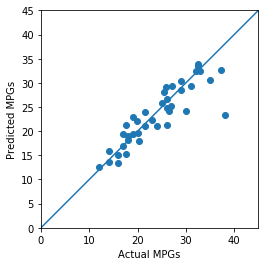

In [21]:
# Step2 - Reset the model and train using different learning rates and optimziers
# in order to acheive a test loss < 0.01

# Load the model weights to the same as initialized
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Select our criterion (MSE Loss) and optimzer (SGD or Adam or experiment with others...)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, nesterov=True)

# Train network for 1000 epochs (experiment with more or less as well)
train(1000, net, train_loader, val_loader, test_loader, criterion, optimizer)

# Display the final results on the test set
graphPredictions(net, test_loader, 0, 45)

### Make your own predictions
After you achieve an average test loss of less than 0.1, you can use the model to make your own predictions. 

In [22]:
# Specify your inputs to your model
df = pd.DataFrame()
df.loc[0,'Cylinders']=8
df.loc[0,'Displacement']=200
df.loc[0,'Horsepower']=200
df.loc[0,'Weight']=2800
df.loc[0,'Acceleration']=15
df.loc[0,'Model Year']=80
df.loc[0,'Origin_Japan']=0
df.loc[0,'Origin_USA']=1

df.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Japan,Origin_USA
0,8.00,200.00,200.00,"2,800.00",15.00,80.00,0.00,1.00


In [23]:
# Normalize the input values using the previously calculate xMean and sStd
xdf = (df-xMean)/xStd
xdf.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Japan,Origin_USA
0,1.48,0.05,2.48,-0.21,-0.20,1.09,-0.50,0.77


In [24]:
# Create a torch tensor for the input
x = torch.tensor(xdf.to_numpy(), dtype=torch.float)

# Set the model to evaluation mode
net = net.eval()

# Perform a single forward pass
pred = net(x)

# Unnormalize the output using yMean and yStd
pred = pred*yStd+yMean

print (f"Predicted MPG: {pred.item():0.4}")

Predicted MPG: 20.69


### Congratulations! 
You have made it to the end of the project!  Once you have achieved a training set loss of less than 0.2, you may submit your project by downloading it and emailing it to us for review.  